# Neural Net | with feature selection and normalized data

**XGBRegressor**

Yo Jeremijenkoko-Conley (based on work by Josie Donnelly)

*Last updated 11.14.22*

In [1]:
import numpy as np
import pandas as pd
#import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout




In [2]:
#!pip install xgboost

In [3]:
os.getcwd()

'/Users/yojeremijenko-conel/Dropbox/Mac (3)/Documents/ocean-depth-characterization/preliminary_models'

## Preprocessing

In [4]:
# load merged dataset
path = '../../DSI_bgcArgoProject/data/'
file = 'float_sat_normalized_depth.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
print(f'Shape: {df_orig.shape}')
df_orig.head()


Shape: (7679754, 31)


,float,latitude,longitude,cycleNumber,date,day_of_year_rad,PRES,PSAL,TEMP,BBP700,...,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,normalized_depth,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,3,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.012931,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,4,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.017241,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,6,35.539001,12.378667,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.025862,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,8,35.539001,12.379000,0.001789,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.034483,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,10,35.539001,12.379000,0.001790,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.043103,0.018,1.600373


In [5]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'normalized_depth', 'CHLA']]
df = df.rename(columns={'cycleNumber': 'cycle'})
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

print(list(df.columns))


['float', 'cycle', 'latitude', 'longitude', 'date', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'normalized_depth', 'CHLA']


In [6]:
# consider only the cycles for which the euphotic floor is within the desired bounds
up_lim = 75
lo_lim = 300
out_of_bounds_df = df[(df['normalized_depth']==1.0) & ((df['PRES']<up_lim) | (df['PRES']>lo_lim))].reset_index(drop=True)
out_of_bounds_df = out_of_bounds_df[['float', 'cycle']]
df = df.merge(right=out_of_bounds_df, how='left', on=['float', 'cycle'], copy=False, indicator='valid')
df = df[df['valid']=='left_only'].drop(columns='valid')
print(f'Shape: {df.shape}')
df.head(5)


Shape: (7679754, 14)


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,0.012931,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,0.017241,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,0.025862,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,0.034483,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,0.043103,0.715552


In [7]:
# drop any example for which there is more than one missing satellite value
sat_feats = ['sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443']
df = df.dropna(axis=0, thresh=len(sat_feats)-1, subset=sat_feats).reset_index(drop=True)

print(f'Raw depth range represented: {min(df["PRES"])}m to {max(df["PRES"])}m')
print(f'Shape: {df.shape}')
df.head(5)


Raw depth range represented: 0m to 300m
Shape: (6590282, 14)


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,0.012931,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,0.017241,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,0.025862,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,0.034483,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,0.043103,0.715552


In [8]:
print(f'Number of examples for which normalized_depth is missing: {df[df["normalized_depth"].isna()].shape[0]}')
# ensure normalized_depth and CHLA are not NA for any observations
df.isna().sum()


Number of examples for which normalized_depth is missing: 0


float                   0
cycle                   0
latitude                0
longitude               0
date                    0
day_of_year_rad         0
sat_chl                 0
sat_sst             36865
sat_pic             60285
sat_par              1509
sat_aph_443          4251
PRES                    0
normalized_depth        0
CHLA                    0
dtype: int64

In [9]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

## Visualize euphotic floor estimates on map

In [10]:
# # function to plot a path of a float cycle on a map, colored by raw depth (PRES) by default
# def plot_on_map(tmp_df, color_by='PRES', cmap='plasma_r', figsize=(10,4), title=None):
#     land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#     land.plot(color='lightgray', figsize=figsize)
#     plt.scatter(tmp_df['longitude'], tmp_df['latitude'], c=tmp_df[color_by], cmap=cmap, s=1, alpha=0.7)
#     cbar = plt.colorbar(label=color_by)
#     cbar.ax.invert_yaxis()
#     if title is None:
#         plt.title(f'Cycle {tmp_df.loc[0,"cycleNumber"]} of Float {tmp_df.loc[0,"float"]}')
#     else:
#         plt.title(title)
#     plt.xlabel('longitude')
#     plt.ylabel('latitude')
    
#     plt.show()
    
# # display the observations colored by the depth of the euphotic floor
# euphotic_floor_df = df[df['normalized_depth']==1.0].reset_index(drop=True)
# plot_on_map(euphotic_floor_df, color_by='PRES', title='Euphotic Floor Estimates\nColored by Raw Depth')


## Train-test split

In [11]:
# read in pre-determined train-test-split
path = '../../DSI_bgcArgoProject/'
file = 'train_test_split.csv'
train_test_split_df = pd.read_csv(path + file)
train_test_split_df = train_test_split_df[['float', 'cycle', 'train']]
train_test_split_df

# # create train-test-split grouped by float and cycle
# df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
# print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')

# split data indices into train and test dataframes grouped by float_cycle_id
# from sklearn.model_selection import GroupShuffleSplit
# splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
# split = splitter.split(df, groups=df['float_cycle_id'])
# train_inds, test_inds = next(split)

# print(f'Number of train observations: {len(train_inds)}')
# print(f'Number of float-cycle observations: {len(test_inds)}')

# # obtain train and test dataframes
# train_df = df.loc[train_inds]
# test_df = df.loc[test_inds]

# # ensure that the train and test float cycles are distinct
# train_float_cycles = np.unique(train_df['float_cycle_id'])
# test_float_cycles = np.unique(test_df['float_cycle_id'])
# print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
# print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
# print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


,float,cycle,train
0,5904858,176,0
1,5904857,76,0
2,5904857,82,0
3,5904672,8,0
4,5905372,64,0
...,...,...,...
58445,7901001,24,1
58446,7901001,25,1
58447,7901001,26,1
58448,7901001,27,1


In [12]:
# notice that different floats may be mentioned in each dataframes
print(f'Number of floats in features df: {len(np.unique(df["float"]))}')
print(f'Number of floats in train-test-split df: {len(np.unique(train_test_split_df["float"]))}')

# merge the two dataframes
df_with_label = df.merge(right=train_test_split_df, how='inner', on=['float', 'cycle'], copy=False)
print(f'\nNumber of floats in merged df: {len(np.unique(df_with_label["float"]))}')

print(f'\nShape: {df_with_label.shape}')
df_with_label


Number of floats in features df: 556
Number of floats in train-test-split df: 565

Number of floats in merged df: 556

Shape: (6590282, 15)


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA,train
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.012931,0.695875,0
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017241,0.695875,0
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.025862,0.696499,0
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.034483,0.716489,0
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.043103,0.715552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6590277,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,156,0.975000,0.013557,1
6590278,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,157,0.981250,0.012949,1
6590279,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,158,0.987500,0.012340,1
6590280,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,159,0.993750,0.011124,1


In [13]:
# ensure the rows of the dataframe are unique, including between train and test
df_with_label.shape[0] == df_with_label.drop(columns='train').drop_duplicates().shape[0]


True

In [14]:
# obtain train and test dataframes
train_df = df_with_label[df_with_label['train']==1].reset_index(drop=True).drop(columns='train')
test_df = df_with_label[df_with_label['train']==0].reset_index(drop=True).drop(columns='train')

print(f'Number of train observations: {train_df.shape[0]}')
print(f'Number of test observations: {test_df.shape[0]}')

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(train_df['float']), list(train_df['cycle']))])
test_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(test_df['float']), list(test_df['cycle']))])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 5303476
Number of test observations: 1286806

Number of unique train float-cycles: 36830
Number of unique test float-cycles: 8953
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [15]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(group_df, features, depth_bin):
    group_data_df = group_df[group_df['depth_bin'] == depth_bin]
    if 'normalized_depth' in group_data_df.columns:
        id_df = group_data_df[['depth_bin', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    else:
        id_df = group_data_df[['depth_bin', 'float', 'cycle', 'date', 'PRES', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    
    group_data_df = group_data_df[features]
    
    return group_data_df, id_df


In [16]:
def standardize(train_data_df, test_data_df, return_scaler=False):
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    if return_scaler:
        return X_train, X_test, y_train, y_test, ss
    return X_train, X_test, y_train, y_test
          

In [17]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [18]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=False, plt_n_cols=5, single_plot=False):  
    if not single_plot:
        plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    if normalized:
        plt.title(f'{int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}%', fontsize='x-large')
    else:
        plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend(loc='lower right')
    

## Neural Net Regressor regressor at varying depths

In [19]:
# define depth bins
interval = 0.1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [20]:
# xgb_feature_train = train_preds
# xgb_feature_test =  test_preds

In [21]:
#len(xgb_feature_train)

In [22]:
#train_data_df.shape

In [31]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test, xgb_train, xgb_test):
    X_train['xgb'] = xgb_train
    X_test['xgb'] = xgb_test
    model.fit(X_train, y_train, batch_size = 256, epochs = 12, verbose=1)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [32]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict_xgbr(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds

In [33]:
def createNueralNetwork():
    # create ANN model
    model = Sequential()

    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(units=10, input_dim=10, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(units=20, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [34]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])

train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'CHLA']
# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'PRES', 'CHLA']


In [35]:
# X_train['xgb'] = xgb_feature_train
# X_test['xgb'] = xgb_feature_test

DEPTH 0: 0% to 10% of the euphotic zone
(515718, 10)
(134231, 10)
(515718, 9)
(134231, 9)
	Num train samples: 515718  |  Num test samples: 134231
Epoch 1/12
   9/2015 [..............................] - ETA: 13s - loss: 0.2261 

2022-11-30 13:46:14.257355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2015/2015 [==============================] - 13s 6ms/step - loss: 0.0322
Epoch 2/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0154
Epoch 3/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0135
Epoch 4/12
2015/2015 [==============================] - 11s 6ms/step - loss: 0.0117
Epoch 5/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0109
Epoch 6/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0103
Epoch 7/12
2015/2015 [==============================] - 14s 7ms/step - loss: 0.0100
Epoch 8/12
2015/2015 [==============================] - 13s 7ms/step - loss: 0.0098
Epoch 9/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0094
Epoch 10/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0093
Epoch 11/12
2015/2015 [==============================] - 13s 6ms/step - loss: 0.0091
Epoch 12/12
2015/2015 [==============================] - 12s 6ms/step - loss: 0.0089


2022-11-30 13:48:44.008506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


	Train MSE: 0.0194  |  Train r2: 0.9028
	Test MSE: 0.0720   |  Test r2: 0.5842
INFO:tensorflow:Assets written to: ram://34e76c12-41b3-4d14-a518-bd33f4c52824/assets


2022-11-30 13:49:26.124455: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



DEPTH 1: 10% to 20% of the euphotic zone
(544309, 10)
(129610, 10)
(544309, 9)
(129610, 9)
	Num train samples: 544309  |  Num test samples: 129610
Epoch 1/12
   1/2127 [..............................] - ETA: 9:32 - loss: 0.2489

2022-11-30 13:49:38.027676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2127/2127 [==============================] - 14s 6ms/step - loss: 0.0337
Epoch 2/12
2127/2127 [==============================] - 14s 7ms/step - loss: 0.0163
Epoch 3/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0161
Epoch 4/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0155
Epoch 5/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0145
Epoch 6/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0133
Epoch 7/12
2127/2127 [==============================] - 12s 6ms/step - loss: 0.0117
Epoch 8/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0109
Epoch 9/12
2127/2127 [==============================] - 12s 6ms/step - loss: 0.0106
Epoch 10/12
2127/2127 [==============================] - 13s 6ms/step - loss: 0.0099
Epoch 11/12
2127/2127 [==============================] - 12s 5ms/step - loss: 0.0100
Epoch 12/12
2127/2127 [==============================] - 12s 6ms/step - loss: 0.0100


2022-11-30 13:52:12.262323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


	Train MSE: 0.0151  |  Train r2: 0.9297
	Test MSE: 0.0827   |  Test r2: 0.5928
INFO:tensorflow:Assets written to: ram://c903240d-6496-4cae-8997-fb04f555e1f5/assets

DEPTH 2: 20% to 30% of the euphotic zone
(540137, 10)
(128754, 10)
(540137, 9)
(128754, 9)
	Num train samples: 540137  |  Num test samples: 128754
Epoch 1/12
   9/2110 [..............................] - ETA: 14s - loss: 0.2562 

2022-11-30 13:53:00.874878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2110/2110 [==============================] - 12s 6ms/step - loss: 0.0294
Epoch 2/12
2110/2110 [==============================] - 13s 6ms/step - loss: 0.0146
Epoch 3/12
2110/2110 [==============================] - 12s 6ms/step - loss: 0.0135
Epoch 4/12
2110/2110 [==============================] - 12s 6ms/step - loss: 0.0114
Epoch 5/12
2110/2110 [==============================] - 13s 6ms/step - loss: 0.0102
Epoch 6/12
2110/2110 [==============================] - 13s 6ms/step - loss: 0.0096
Epoch 7/12
2110/2110 [==============================] - 14s 7ms/step - loss: 0.0090
Epoch 8/12
1322/2110 [=================>............] - ETA: 4s - loss: 0.0086

KeyboardInterrupt: 

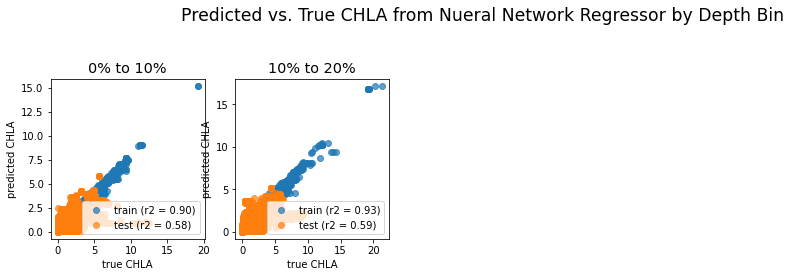

In [36]:
# fit a Mixed model that uses XGBR as a feature for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(16,len(bins)-1))
plt.suptitle('Predicted vs. True CHLA from Nueral Network Regressor by Depth Bin\n\n', fontsize='xx-large')
model_path =  '../nueral_net_models/'

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')
    
    # obtain train and test data for this bin
    train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features, depth_bin=depth_idx)
    test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features, depth_bin=depth_idx)
    #train_data_df['xgb'] = xgb_feature_train
    #test_data_df['xgb'] = xgb_feature_test
    train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
    test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])
    
    print(train_data_df.shape)
    print(test_data_df.shape)
    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)
    print(X_train.shape)
    print(X_test.shape)
    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    

    xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    xgb_feature_train, xgb_feature_test = fit_predict_xgbr(xgbr, X_train, y_train, X_test, y_test)

    # train, predict, and get scores for XGBoosting regressor
    nnr = createNueralNetwork() #XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(nnr, X_train, y_train, X_test, y_test, xgb_feature_train, xgb_feature_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, plt_n_cols=5)
    
    # add scores and predictions to respective dataframes
    results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    train_predictions_for_depth_df['pred_CHLA'] = train_preds
    train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
    test_predictions_for_depth_df['pred_CHLA'] = test_preds
    test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])
    
    # save the model for this depth bin
    model_file = 'nueral_net_model_depth_bin_{depth_idx}'
    try:
        pickle.dump(nnr, open(model_path + model_file, 'wb'))
    except:
        os.mkdir(model_path)
        pickle.dump(nnr, open(model_path + model_file, 'wb'))
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


In [ ]:
#X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
'''
Output exceeds the size limit. Open the full output data in a text editor
DEPTH 0: 0% to 10% of the euphotic zone
	Num train samples: 510879  |  Num test samples: 133206
	Train MSE: 0.0069  |  Train r2: 0.9688
	Test MSE: 0.0737   |  Test r2: 0.6039

DEPTH 1: 10% to 20% of the euphotic zone
	Num train samples: 539835  |  Num test samples: 128436
	Train MSE: 0.0067  |  Train r2: 0.9689
	Test MSE: 0.0744   |  Test r2: 0.5560

DEPTH 2: 20% to 30% of the euphotic zone
	Num train samples: 535847  |  Num test samples: 127666
	Train MSE: 0.0073  |  Train r2: 0.9668
	Test MSE: 0.0844   |  Test r2: 0.5515

DEPTH 3: 30% to 40% of the euphotic zone
	Num train samples: 538502  |  Num test samples: 128500
	Train MSE: 0.0077  |  Train r2: 0.9639
	Test MSE: 0.0747   |  Test r2: 0.6034

DEPTH 4: 40% to 50% of the euphotic zone
	Num train samples: 537904  |  Num test samples: 128830
	Train MSE: 0.0078  |  Train r2: 0.9622
	Test MSE: 0.0764   |  Test r2: 0.5887
...
	Num train samples: 531118  |  Num test samples: 128970
	Train MSE: 0.0074  |  Train r2: 0.9649
	Test MSE: 0.0921   |  Test r2: 0.5763
'''

'\nOutput exceeds the size limit. Open the full output data in a text editor\nDEPTH 0: 0% to 10% of the euphotic zone\n\tNum train samples: 510879  |  Num test samples: 133206\n\tTrain MSE: 0.0069  |  Train r2: 0.9688\n\tTest MSE: 0.0737   |  Test r2: 0.6039\n\nDEPTH 1: 10% to 20% of the euphotic zone\n\tNum train samples: 539835  |  Num test samples: 128436\n\tTrain MSE: 0.0067  |  Train r2: 0.9689\n\tTest MSE: 0.0744   |  Test r2: 0.5560\n\nDEPTH 2: 20% to 30% of the euphotic zone\n\tNum train samples: 535847  |  Num test samples: 127666\n\tTrain MSE: 0.0073  |  Train r2: 0.9668\n\tTest MSE: 0.0844   |  Test r2: 0.5515\n\nDEPTH 3: 30% to 40% of the euphotic zone\n\tNum train samples: 538502  |  Num test samples: 128500\n\tTrain MSE: 0.0077  |  Train r2: 0.9639\n\tTest MSE: 0.0747   |  Test r2: 0.6034\n\nDEPTH 4: 40% to 50% of the euphotic zone\n\tNum train samples: 537904  |  Num test samples: 128830\n\tTrain MSE: 0.0078  |  Train r2: 0.9622\n\tTest MSE: 0.0764   |  Test r2: 0.5887\n

## Display XGBoost regressor results

In [ ]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df


NameError: name 'results_df' is not defined

<!-- 
Average train r2: 0.5679939793256079
Average test r2: 0.5257214364013001

Maximum train r2: 0.6090744091005458
Maximum test r2: 0.5924858693816069 -->


In [ ]:
# Average train r2: 0.9661335665416322
# Average test r2: 0.5816735239615706

# Maximum train r2: 0.9688580128792292
# Maximum test r2: 0.607433290555819

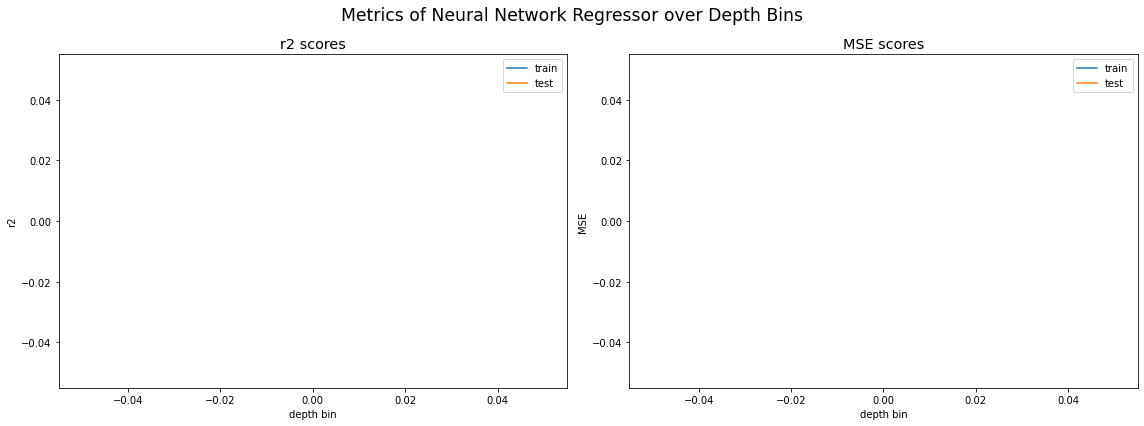

In [ ]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of Neural Network Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


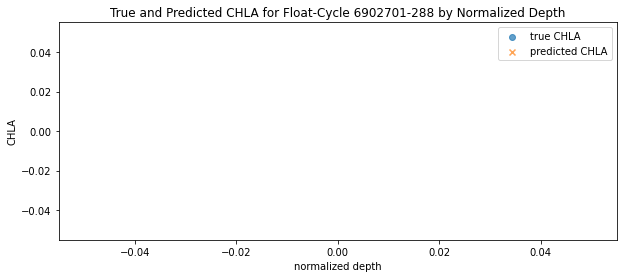

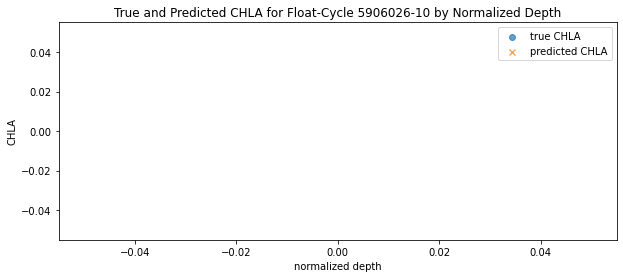

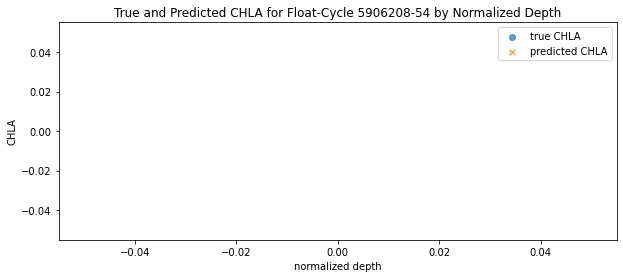

In [ ]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(10,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [ ]:
# save results and predictions
result_path = path + ''
results_df.to_csv(result_path + 'results_NN_feature_selection_normalized_yxj.csv', index=False)
train_predictions_df.to_csv(result_path + 'NN_train_preds.csv', index=False)
test_predictions_df.to_csv(result_path + 'NN_test_preds.csv', index=False)


## Repeat for one NN model over all depths

In [37]:
# define depth bins
interval = 1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [38]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])

train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'CHLA']
# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'PRES', 'CHLA']


In [39]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(8,8))
plt.suptitle('Predicted vs. True CHLA from Neural Net Regressor by Depth Bin\n\n', fontsize='large')
model_path = path + 'NN_single_model/'

depth_idx = 0

if verbose > 0:
    print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')

# obtain train and test data for this bin
train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features, depth_bin=depth_idx)
test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features, depth_bin=depth_idx)

train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])

# standardize features based on training data
X_train, X_test, y_train, y_test, ss = standardize(train_data_df, test_data_df, return_scaler=True)

if verbose > 0:
    print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
    print(f'Num test samples: {X_test.shape[0]}')

# train, predict, and get scores for XGBoosting regressor

xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
xgb_feature_train, xgb_feature_test = fit_predict_xgbr(xgbr, X_train, y_train, X_test, y_test)


nnr = createNueralNetwork()#XGBRegressor(n_estimators=20, max_depth=10, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
train_preds, test_preds = fit_predict(nnr, X_train, y_train, X_test, y_test, xgb_feature_train, xgb_feature_test)

if verbose > 0: 
    print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
    print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
    print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
    print(f'Test r2: {r2_score(y_test, test_preds):.4f}')

# plot predictions vs. true values
plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, single_plot=True)

# add scores and predictions to respective dataframes
results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
train_predictions_for_depth_df['pred_CHLA'] = train_preds
train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
test_predictions_for_depth_df['pred_CHLA'] = test_preds
test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])

# save the model for this depth bin
model_file = 'NN_model'
try:
    pickle.dump(nnr, open(model_path + model_file, 'wb'))
except:
    os.mkdir(model_path)
    pickle.dump(nnr, open(model_path + model_file, 'wb'))

if verbose > 0:
    print()
        
plt.tight_layout()
plt.show()


DEPTH 0: 0% to 100% of the euphotic zone
	Num train samples: 5303476  |  Num test samples: 1286806
Epoch 1/12
    1/20717 [..............................] - ETA: 1:32:46 - loss: 0.1554

2022-11-30 13:55:05.258316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20717/20717 [==============================] - 125s 6ms/step - loss: 0.0272
Epoch 2/12
20717/20717 [==============================] - 119s 6ms/step - loss: 0.0216
Epoch 3/12
20717/20717 [==============================] - 126s 6ms/step - loss: 0.0213
Epoch 4/12
20717/20717 [==============================] - 127s 6ms/step - loss: 0.0211
Epoch 5/12
20717/20717 [==============================] - 119s 6ms/step - loss: 0.0211
Epoch 6/12
20717/20717 [==============================] - 126s 6ms/step - loss: 0.0211
Epoch 7/12
20717/20717 [==============================] - 129s 6ms/step - loss: 0.0210
Epoch 8/12
20717/20717 [==============================] - 129s 6ms/step - loss: 0.0209
Epoch 9/12
20717/20717 [==============================] - 128s 6ms/step - loss: 0.0209
Epoch 10/12
20717/20717 [==============================] - 126s 6ms/step - loss: 0.0210
Epoch 11/12
20717/20717 [==============================] - 130s 6ms/step - loss: 0.0209
Epoch 12/12
20717/20717 [===========================

2022-11-30 14:20:15.703077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Train MSE: 0.0822  |  Train r2: 0.5897
# 	Test MSE: 0.0847   |  Test r2: 0.5619

In [ ]:
results_df

In [ ]:
results_df


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 100)",6590282,0.082218,0.589726,0.084694,0.561862


In [ ]:
# display the dataframe of results
results_df


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 100)",6590282,0.082218,0.589726,0.084694,0.561862


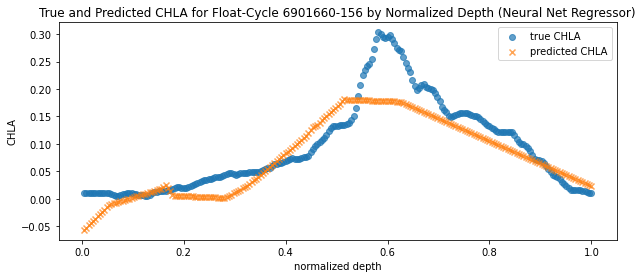

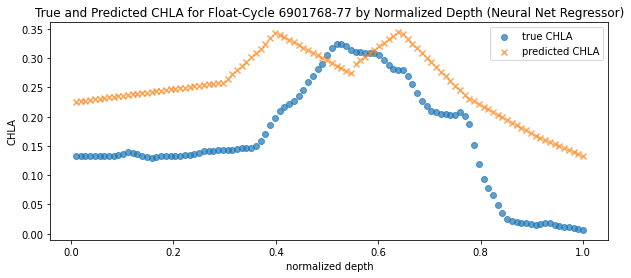

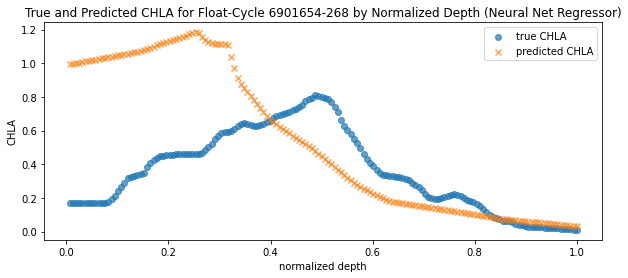

In [ ]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(10,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth (Neural Net Regressor)')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [ ]:
# save results and predictions
results_df.to_csv(result_path + 'results_NN_single_model_feature_selection_normalized_yxj.csv', index=False)
train_predictions_df.to_csv(result_path + 'NN_single_model_train_preds.csv', index=False)
test_predictions_df.to_csv(result_path + 'NN_single_model_test_preds.csv', index=False)


## Inference: the process if given only unseen satellite data

/Users/yojeremijenko-conel/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- raw_depth
Feature names seen at fit time, yet now missing:
- PRES

  warnings.warn(message, FutureWarning)


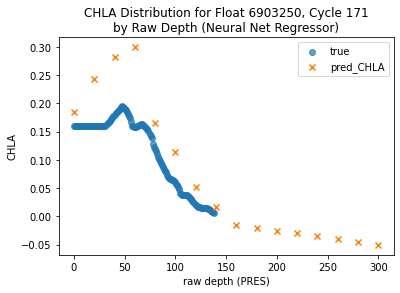

/Users/yojeremijenko-conel/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- raw_depth
Feature names seen at fit time, yet now missing:
- PRES

  warnings.warn(message, FutureWarning)


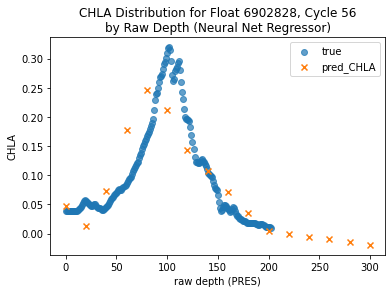

/Users/yojeremijenko-conel/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- raw_depth
Feature names seen at fit time, yet now missing:
- PRES

  warnings.warn(message, FutureWarning)


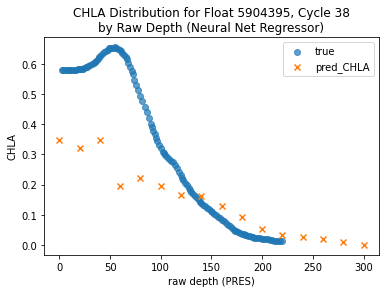

In [ ]:
num = 3
for i in range(num):
    # choose a random float-cycle from the test data
    f = random.choice(test_df['float'])
    float_df = test_df[test_df['float']==f]
    c = random.choice(np.unique(float_df['cycle']))
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'raw_depth': np.arange(0,320,20)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['PRES'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true')
    plt.scatter(feats_df['raw_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}\nby Raw Depth (Neural Net Regressor)')
    plt.xlabel('raw depth (PRES)')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()


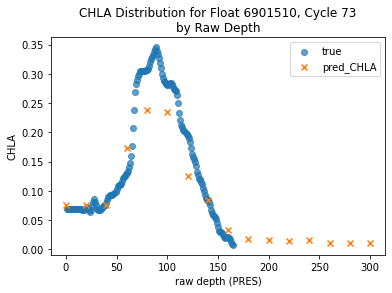

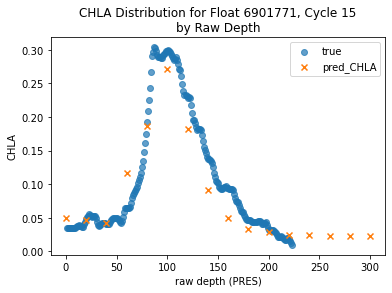

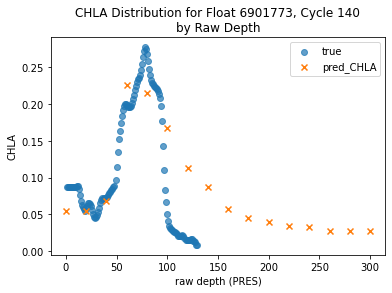

In [ ]:
num = 3
for i in range(num):
    # choose a random float-cycle from the test data
    f = random.choice(test_df['float'])
    float_df = test_df[test_df['float']==f]
    c = random.choice(np.unique(float_df['cycle']))
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'raw_depth': np.arange(0,320,20)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['PRES'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true')
    plt.scatter(feats_df['raw_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}\nby Raw Depth')
    plt.xlabel('raw depth (PRES)')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
